In [ ]:
import gzip
import pickle
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import random
from pathlib import Path
from collections import Counter
from tqdm import tqdm

from src.tokenizer import Tokenizer

DATA_DIR = Path("../data/val") 
NUM_CHUNKS_TO_CHECK = 11
NUM_SAMPLES_TO_VISUALIZE = 5


PAD_TOKEN_ID = 0
SOS_TOKEN_ID = 1
EOS_TOKEN_ID = 2


tokenizer = Tokenizer()


def get_token_name(token_obj):
    """Преобразует ID/объект токена в читаемую строку. Доступна глобально."""
    if isinstance(token_obj, str): return token_obj
    if isinstance(token_obj, int): return str(token_obj)
    if hasattr(token_obj, '__name__'): return token_obj.__name__
    return str(token_obj)

In [12]:
def process_data(data_dir, num_chunks, num_samples_to_keep=5):
    global_token_counts = Counter()
    global_seq_lengths = []
    
    sample_buffer = []
    
    total_samples = 0
    loaded_chunks = 0
    
    print(f"🔄 Запуск единого прохода: сбор статистики и примеров по {num_chunks} чанкам...")
    
    for i in tqdm(range(num_chunks), desc="Processing chunks"):
        file_path = data_dir / f"chunk_{i}.pkl.gz"
        
        if not file_path.exists():
            continue
            
        try:
            with gzip.open(file_path, 'rb') as f:
                chunk_data = pickle.load(f)
                
            loaded_chunks += 1
            total_samples += len(chunk_data)
            
            for item in chunk_data:
                toks = item['tokens']
                valid_toks = toks[toks != PAD_TOKEN_ID]
                
                global_token_counts.update(valid_toks)
                global_seq_lengths.append(len(valid_toks))
            

            if len(sample_buffer) < 100:
                k = min(len(chunk_data), 5)
                sample_buffer.extend(random.sample(chunk_data, k))
            
            del chunk_data
            
        except Exception as e:
            print(f"❌ Ошибка при чтении {file_path}: {e}")

    final_samples = []
    if sample_buffer:
        count = min(len(sample_buffer), num_samples_to_keep)
        final_samples = random.sample(sample_buffer, count)

    print(f"\n✅ Готово. Загружено чанков: {loaded_chunks}")
    print(f"📊 Всего проанализировано примеров: {total_samples}")
    
    return global_token_counts, global_seq_lengths, final_samples

In [13]:
agg_counts, agg_lengths, random_examples = process_data(
    DATA_DIR, 
    NUM_CHUNKS_TO_CHECK, 
    num_samples_to_keep=NUM_SAMPLES_TO_VISUALIZE
)

🔄 Запуск единого прохода: сбор статистики и примеров по 216 чанкам...


Processing chunks: 100%|██████████| 216/216 [00:40<00:00,  5.28it/s]


✅ Готово. Загружено чанков: 216
📊 Всего проанализировано примеров: 1080000


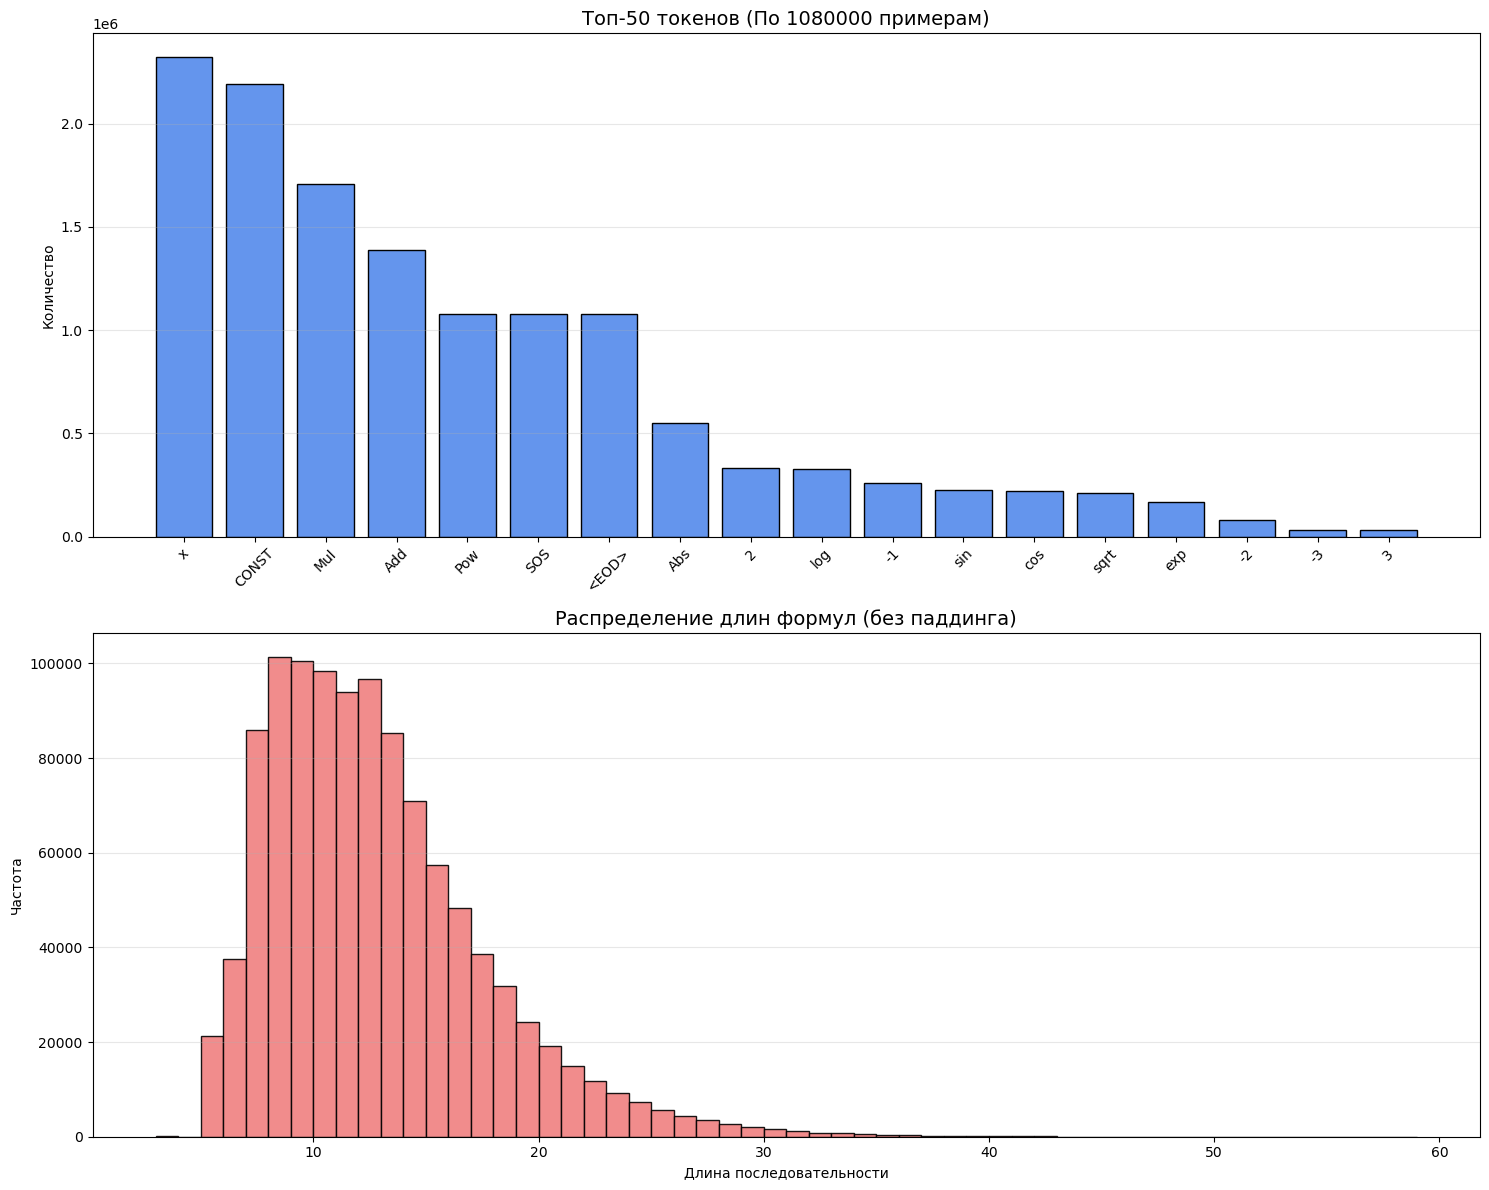

In [14]:
def plot_aggregated_stats(token_counts, seq_lengths, tokenizer):
    if not token_counts:
        print("⚠️ Нет данных для отображения.")
        return

    labels = []
    values = []
    
    for token_id, count in token_counts.most_common(50):
        if 0 <= token_id < len(tokenizer.id_map):
            token_obj = tokenizer.id_map[token_id]
            name = get_token_name(token_obj)
        else:
            name = f"Unk({token_id})"
            
        labels.append(name)
        values.append(count)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    
    ax1.bar(labels, values, color='cornflowerblue', edgecolor='black')
    ax1.set_title(f'Топ-50 токенов (По {len(seq_lengths)} примерам)', fontsize=14)
    ax1.set_ylabel('Количество')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(axis='y', alpha=0.3)
    

    if seq_lengths:
        bins = range(min(seq_lengths), max(seq_lengths) + 2)
        ax2.hist(seq_lengths, bins=bins, color='lightcoral', edgecolor='black', alpha=0.9)
        ax2.set_title('Распределение длин формул (без паддинга)', fontsize=14)
        ax2.set_xlabel('Длина последовательности')
        ax2.set_ylabel('Частота')
        ax2.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()


plot_aggregated_stats(agg_counts, agg_lengths, tokenizer)

📈 Отображение 5 случайных примеров:


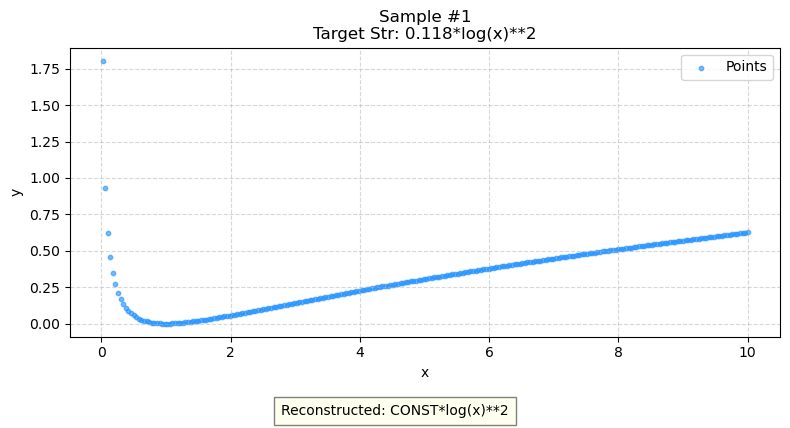

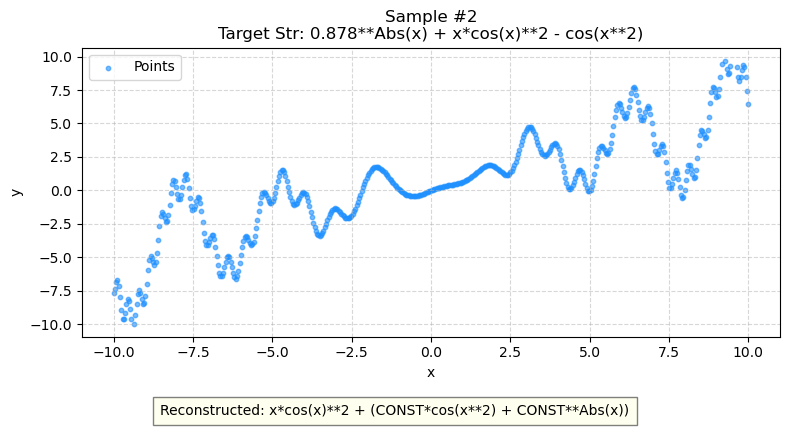

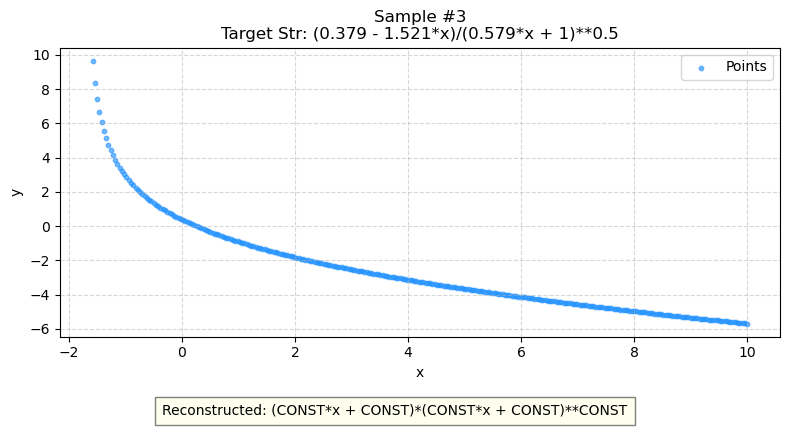

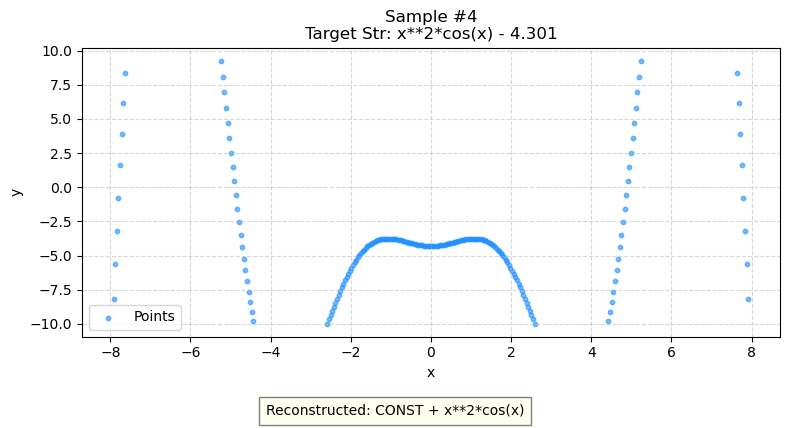

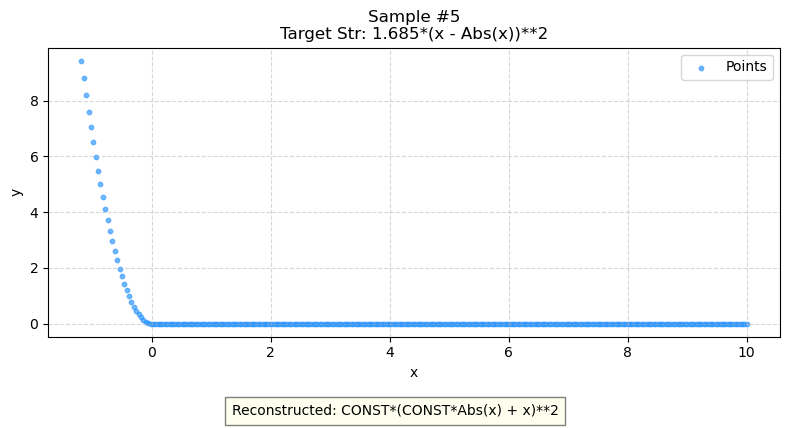

In [15]:
def visualize_collected_samples(samples, tokenizer):
    if not samples:
        print("⚠️ Нет примеров для отображения.")
        return

    print(f"📈 Отображение {len(samples)} случайных примеров:")

    for i, item in enumerate(samples):
        expr_str = item.get('expr_str', 'N/A')
        tokens = item['tokens']
        points = item['points']
        
        mask_special = (tokens != PAD_TOKEN_ID) & (tokens != SOS_TOKEN_ID) & (tokens != EOS_TOKEN_ID)
        clean_tokens = tokens[mask_special]
        
        try:
            reconstructed = tokenizer.token_seq_to_expr(clean_tokens)
        except Exception as e:
            reconstructed = f"Error reconstructing: {e}"

        if points.shape[1] >= 3:
            x = points[:, 0]
            y = points[:, 1]
            valid_mask = points[:, 2].astype(bool)
            x_plot, y_plot = x[valid_mask], y[valid_mask]
        else:
            x_plot, y_plot = points[:, 0], points[:, 1]
        
        plt.figure(figsize=(8, 4))
        plt.scatter(x_plot, y_plot, s=10, c='dodgerblue', alpha=0.6, label='Points')
        
        plt.title(f"Sample #{i+1}\nTarget Str: {expr_str}")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.legend()
        
        plt.figtext(0.5, -0.05, f"Reconstructed: {reconstructed}", 
                    ha="center", fontsize=10, 
                    bbox=dict(facecolor="lightyellow", alpha=0.5, pad=5))
        
        plt.tight_layout()
        plt.show()

visualize_collected_samples(random_examples, tokenizer)